In [84]:
import numpy as np
import time
from random import random
import matplotlib.pyplot as plt
from scipy.spatial import KDTree
from plotly.offline import download_plotlyjs, init_notebook_mode, plot, iplot
import plotly.graph_objs as go
init_notebook_mode(connected=True)


# Goal

The goal of this notebook is to explore better methods for the final l2 centorid match during registration in the pipeline.

# Generate Data

In [15]:
def newRandomCentroids(n, l, u):
    diff = u-l
    return [[random()*diff+l for _ in range(3)] for _ in range(n)]

In [16]:
newRandomCentroids(10, 10, 100)

[[95.55437841167756, 88.33164728326365, 15.767673631991798],
 [21.977857463919126, 48.42713895362624, 68.92061030885175],
 [96.18180929049173, 65.30600160116484, 59.52867191743741],
 [87.81411179245515, 48.73356780265207, 47.55505692189131],
 [53.9257575398029, 45.19203422343768, 19.64168112571526],
 [78.33816719831569, 18.832925298826744, 74.94233761464585],
 [84.6875980471348, 11.848028543700389, 81.30189876118224],
 [36.753112986104206, 35.040149644089944, 55.36953526705242],
 [16.820296171346115, 84.66512194163141, 77.84319787748771],
 [75.76630945448031, 51.56658687960156, 84.1894286281471]]

# Benchmark Current Approach

In [40]:
def l2(a, b):
    return np.sqrt(np.sum(np.power(np.subtract(a, b), 2)))

def bruteMatch(A, B, r):
    pairs = []
    for a in A:
        loss = [l2(a, b) for b in B]
        if np.min(loss) < r:
            pairs.append([a, B[np.argmin(loss)]])
        else:
            pairs.append([a, [0, 0, 0]])
    return pairs

In [72]:
def makePairSet(n, l, u, o):    
    A = newRandomCentroids(n, l, u)
    B = [[(elem[0]+random()*o)-o/2, (elem[1]+random()*o)-o/2, (elem[2]+random()*o)-o/2] for elem in A]
    return A, B

In [75]:
A, B = makePairSet(10, 0, 100, 10)

In [76]:
reshapeA = zip(*(A))
reshapeB = zip(*(B))

trace1 = go.Scatter3d(
    x = reshapeA[0],
    y = reshapeA[1],
    z = reshapeA[2],
    mode = 'markers',
    marker = dict(
        size=12,
        color=100,
        opacity=.7
    )
)

trace2 = go.Scatter3d(
    x = reshapeB[0],
    y = reshapeB[1],
    z = reshapeB[2],
    mode = 'markers',
    marker = dict(
        size=12,
        color=0,
        opacity=.710
    )
)

data = [trace1, trace2]

layout = go.Layout(margin=dict(l=0, r=0, t=0, b=0))
fig = go.Figure(data=data, layout=layout)
iplot(fig)

In [77]:
pairs = bruteMatch(A, B, 100)

In [79]:
data = []
for pair in pairs:
    i = "rgb(" + str(random()*255) + ',' + str(random()*255) + ',' + str(random()*255)+')'
    data.append(go.Scatter3d(
            x = zip(*(pair))[0],
            y = zip(*(pair))[1],
            z = zip(*(pair))[2],
            marker = dict(size=12, color=i, opacity=.7),
            line = dict(color=i, width=1)
        )
    )
    
fig = go.Figure(data=data, layout=layout)
iplot(fig)

In [83]:
timeStats = []
for i in range(2000,10000,2000):
    A, B = makePairSet(i, 0, 1000, 100)
    print i
    s = time.time()
    pairs = bruteMatch(A, B, 100)
    e = time.time()
    timeStats.append([i, e-s])

2000
4000
6000
8000


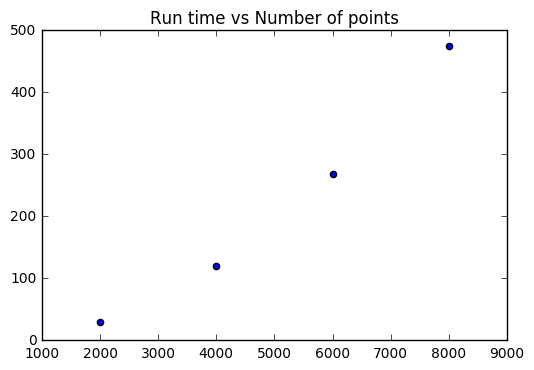

In [89]:
plt.figure()
plt.title('Run time vs Number of points')
x, y = zip(*(timeStats))
plt.scatter(x, y)
plt.show()

# KD Tree Matching
In order to solve the runtime issue, I decided to perform only 1-nearest neighbor lookups (since thats what we really care about). The KD tree implements this in log(n) for the time of the lookup, with nlog(n) overhead for building the tree.

In [96]:
def KDMatch(A, B, r):
    tree = KDTree(B)
    pairs = []
    for a in A:
        dist, idx = tree.query(a, k=1, distance_upper_bound = r)
        if dist == float('Inf'):
            pairs.append(a, [0, 0, 0])
        else:
            pairs.append([a, B[idx]])
    return pairs

In [91]:
A, B = makePairSet(10, 0, 100, 10)

In [92]:
reshapeA = zip(*(A))
reshapeB = zip(*(B))

trace1 = go.Scatter3d(
    x = reshapeA[0],
    y = reshapeA[1],
    z = reshapeA[2],
    mode = 'markers',
    marker = dict(
        size=12,
        color=100,
        opacity=.7
    )
)

trace2 = go.Scatter3d(
    x = reshapeB[0],
    y = reshapeB[1],
    z = reshapeB[2],
    mode = 'markers',
    marker = dict(
        size=12,
        color=0,
        opacity=.710
    )
)

data = [trace1, trace2]

layout = go.Layout(margin=dict(l=0, r=0, t=0, b=0))
fig = go.Figure(data=data, layout=layout)
iplot(fig)

In [97]:
pairs = KDMatch(A, B, 10)

In [100]:
data = []
for pair in pairs:
    i = "rgb(" + str(random()*255) + ',' + str(random()*255) + ',' + str(random()*255)+')'
    data.append(go.Scatter3d(
            x = zip(*(pair))[0],
            y = zip(*(pair))[1],
            z = zip(*(pair))[2],
            marker = dict(size=12, color=i, opacity=.7),
            line = dict(color=i, width=1)
        )
    )
    
fig = go.Figure(data=data, layout=layout)
iplot(fig)

In [101]:
timeStats = []
for i in range(2000,10000,2000):
    A, B = makePairSet(i, 0, 1000, 100)
    print i
    s = time.time()
    pairs = KDMatch(A, B, 100)
    e = time.time()
    timeStats.append([i, e-s])

2000
4000
6000
8000


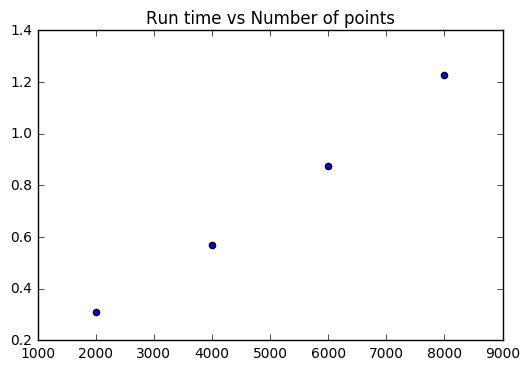

In [102]:
plt.figure()
plt.title('Run time vs Number of points')
x, y = zip(*(timeStats))
plt.scatter(x, y)
plt.show()

In [104]:
kdTimeStats = []
bruteTimeStats = []
for i in range(2000,10000,2000):
    A, B = makePairSet(i, 0, 1000, 100)
    print i
    
    s = time.time()
    pairs = KDMatch(A, B, 100)
    e = time.time()
    kdTimeStats.append([i, e-s])
    
    s = time.time()
    pairs = bruteMatch(A, B, 100)
    e = time.time()
    bruteTimeStats.append([i, e-s])

2000
4000
6000
8000
